# Clasificación no supervisada con serie temporal NDVI de Terra/MODIS

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.1 MB/s eta 0:00:00


### Cargar librerías

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-my-francodbarr')

In [ ]:
#importar librerías

import pandas as pd
import numpy as np
from datetime import datetime as dt
import geemap
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.geometry import Point
import rasterio
import random

Funciones

In [ ]:
def getCoordsSHP(gdfshpFile):
  '''
  This function takes a polygon vector layer file passed as a GeoDataFrame. Then
  it gets all the coordinates as a tuple of tuples.
  '''

  gdfiterf = gdfshpFile.iterfeatures()
  tupleFile = next(gdfiterf)['geometry']['coordinates']

  return tupleFile

### Seleccionar la colección y filtrarla

In [ ]:
#selecciona la colección MODIS MOD13Q1 NDVI
MODIS = ee.ImageCollection('MODIS/006/MOD13Q1').select('NDVI') ##MOD13Q1.061 Terra Vegetation Indices 16-Day Global 250m

## establece el rango de fechas de interés
startDate = '2000-02-18'
endDate = '2022-12-31' ## la coleccion llega hasta 2023-02-02, aunque se informa que llega hasta julio 2023 (búsqueda agosto)

# filtrar por fechas
MODIS = MODIS.filterDate(startDate, endDate)

Vector areas seleccionadas-arroceras primer kmeans

In [ ]:
# Arroceras primer kmeans - https://drive.google.com/file/d/1RW0CshCCqytF3JP4eqmNCgfumdfA0C1Q/view?usp=sharing

!gdown --id 1RW0CshCCqytF3JP4eqmNCgfumdfA0C1Q
!unzip kmeans_seleccion_vectorizado_primerclasf

targetCRS = "EPSG:4326"
vector1CKm = gpd.read_file('/content/kmeans_seleccion_vectorizado.shp').to_crs(targetCRS)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RW0CshCCqytF3JP4eqmNCgfumdfA0C1Q
To: /content/kmeans_seleccion_vectorizado_primerclasf.zip
100% 33.0k/33.0k [00:00<00:00, 83.9MB/s]
Archive:  kmeans_seleccion_vectorizado_primerclasf.zip
  inflating: kmeans_seleccion_vectorizado.cpg  
  inflating: kmeans_seleccion_vectorizado.dbf  
  inflating: kmeans_seleccion_vectorizado.prj  
  inflating: kmeans_seleccion_vectorizado.qmd  
  inflating: kmeans_seleccion_vectorizado.shp  
  inflating: kmeans_seleccion_vectorizado.shx  


<Axes: >

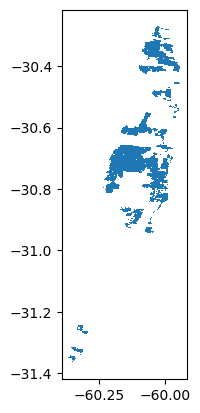

In [ ]:
vector1CKm.plot()

In [ ]:
listIDs = list(vector1CKm['fid'])

listPolys = []

for ID in listIDs:
  listOfLists = [list(coords) for coords in getCoordsSHP(vector1CKm[vector1CKm['fid']==ID])[0]]
  listPolys.append(ee.Geometry.Polygon(listOfLists))

featureCollection02 = ee.FeatureCollection(listPolys)

In [ ]:
featureCollection02

In [ ]:
# ver tamaño de la colección - es una colección con 528 elementos en mi área de prueba - 526 si dejo hasta diciembre 2022
MODIS

In [ ]:
# Define a function to unmask the NDVI band
def unmaskNDVI(image):
    return image.select('NDVI').unmask(-2000)

# Map the unmask function over the entire collection
MODIS_unmasked = MODIS.map(unmaskNDVI)

In [ ]:
# Convertir la colección a un stack - una imagen de NDVI por fecha
MODIS_stack = MODIS_unmasked.toBands()

MODIS_stack # ya no es una colección, es una imagen con 526 bandas en mi área de prueba

In [ ]:
#cortar con un shapefile
MODIS_stack = MODIS_stack.clipToCollection(featureCollection02)

In [ ]:
# El kmeans de GEE necesita entrenar al menos con puntos al azar
# Te pide que le des puntos al azar para inicializar el algoritmo
# NO DAR muestras de entrenamiento

# Fuente: https://developers.google.com/earth-engine/guides/clustering

#Define a region in which to generate a sample of the input.

#primero defino las variables que piden más abajo
region = featureCollection02
scale = 250 ## este es el tamaño de pixel de MODIS en esta colección
#scale = 231.65635826395825 ## este es el tamaño de pixel de MODIS en esta colección

numPixels = 5000 # puntos de inicializacion --> no son de entrenamiento

# Make the training dataset, except for -999 (mascara)
#MODIS_randomtraining = MODIS_stack.sample(region = region, scale = scale, numPixels = numPixels)

MODIS_randomtraining = MODIS_stack.sample(region=region, scale=scale, numPixels=numPixels)

In [ ]:
# Iniciar una clasificación kmeans con N clusters

num_clusters = 40 # numero de clases # del primer kmeans se seleccionaron 12 clases
seed = 42 # configurar la semillar para garantizar la reproducibilidad
kmeans = ee.Clusterer.wekaKMeans(num_clusters, seed=seed).train(MODIS_randomtraining)

In [ ]:
# Aplica la clasificación a la imagen
MODIS_kmeans = MODIS_stack.cluster(kmeans) # cada pixel va de 0-n_clusters-1

MODIS_kmeans = MODIS_kmeans.add(1) #sumar 1 para que no empiece en 0 el cluster numbering
# cada pixel va de 1-n_clusters

MODIS_kmeans = MODIS_kmeans.clip(featureCollection02)

In [ ]:
MODIS_kmeans # es una imagen de una banda, lo que está bien. espero que sea una clasificación.

In [ ]:
# generar mapa

# ver clasificación - en Python

Map = geemap.Map(center=(-32.06, -60.62), zoom=9)
Map.addLayer(MODIS_kmeans)

#Map

Map(center=[-32.06, -60.62], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
#https://worldbank.github.io/OpenNightLights/tutorials/mod3_7_import_export_data.html

task = ee.batch.Export.image.toDrive(
        image = MODIS_kmeans.toDouble(),
        scale=scale,
        region = featureCollection02.geometry().bounds(), # Or use custom ee.Geometry.Rectangle([minlon, minlat, maxlon, maxlat])
        description = 'MODIS_MOD13Q1_NDVI_kmeans40-24-03.tif',
        crs = 'EPSG:4326',
        maxPixels = 1e10,
        fileFormat = "GeoTIFF",
        folder ='earthengine'
  )

task.start()

## Resumen de las clases

#### Extraccion de los datos para su visualizacion en forma de SSTT de NDVI

In [ ]:
# https://drive.google.com/file/d/1p7phVeqZSIW52HUiy7o7y8xnTInPZCVf/view?usp=sharing

!gdown --id 1p7phVeqZSIW52HUiy7o7y8xnTInPZCVf

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1p7phVeqZSIW52HUiy7o7y8xnTInPZCVf
To: /content/MODIS_MOD13Q1_NDVI_kmeans40-24-03.tif.tif
100% 24.1k/24.1k [00:00<00:00, 94.6MB/s]


In [ ]:
seed_random = 42
random.seed(seed_random)

In [ ]:
# Load raster classification
raster_file = "/content/MODIS_MOD13Q1_NDVI_kmeans40-24-03.tif.tif"
with rasterio.open(raster_file) as src:
    classification = src.read(1)
    transform = src.transform
    num_clusters = len(np.unique(classification))

# Create vector layer with random points
num_points_per_cluster = 100 #
#num_points_per_cluster = 5 #prueba con pocos puntos

points = []
cluster_numbers = []

for cluster_id in range(1, num_clusters + 1):
    cluster_indices = np.where(classification == cluster_id)
    sample_indices = random.sample(range(len(cluster_indices[0])), min(num_points_per_cluster, len(cluster_indices[0])))

    for index in sample_indices:
        row, col = cluster_indices[0][index], cluster_indices[1][index]
        x, y = rasterio.transform.xy(transform, row, col)
        points.append(Point(x, y))
        cluster_numbers.append(cluster_id)


# Create a GeoDataFrame from the points
data = {'geometry': points, 'cluster': cluster_numbers}
gdf = gpd.GeoDataFrame(data, crs=src.crs)

# Save the GeoDataFrame to a shapefile
output_shapefile = "kmeans_random_points_2dokmeans.shp"
gdf.to_file(output_shapefile)

print("Random points saved to:", output_shapefile)

Random points saved to: kmeans_random_points_2dokmeans.shp


In [ ]:
modis_collection = MODIS
#modis_collection = MODIS.filterDate("2022-01-01", "2022-01-31") #prueba con pocas imagenes

clusters = gdf["cluster"].unique()

# Create a function to extract NDVI values for a point
def get_ndvi_for_point(feature):
    point = feature.geometry()
    ndvi_values = modis_collection.getRegion(point, scale=250).getInfo()
    return ndvi_values

# Loop through each cluster and extract NDVI values for each point
ndvi_data = []

for cluster in clusters:
    cluster_gdf = gdf[gdf["cluster"] == cluster]
    for index, row in cluster_gdf.iterrows():
        point = Point(row["geometry"].x, row["geometry"].y)
        feature = ee.Feature(ee.Geometry.Point(point.x, point.y))
        ndvi_values = get_ndvi_for_point(feature)

        # Extract NDVI values for each scene
        for scene_values in ndvi_values[1:]:
            timestamp_milliseconds = int(scene_values[3])
            timestamp_seconds = timestamp_milliseconds / 1000
            dt_object = dt.utcfromtimestamp(timestamp_seconds)
            formatted_date = dt_object.strftime('%Y-%m-%d')

            scene_ndvi_values = scene_values[4:]
            ndvi_data.append([cluster, point.x, point.y, formatted_date, *scene_ndvi_values])

# Create a dataframe from the extracted data
columns = ["cluster", "longitude", "latitude", "date"] + ["NDVI" + str(i) for i in range(1, len(ndvi_data[0]) - 3)]
ndvi_df = pd.DataFrame(ndvi_data, columns=columns)

# NOTA: este paso para el Delta tarda unas 2 horas

In [ ]:
#llenar los NoData con -2000 (igual que hicimos en la imagen con unmask, ahora lo hace en la tabla)
ndvi_df = ndvi_df.fillna(-2000)

In [ ]:
# Display the dataFrame
ndvi_df

cluster  longitude   latitude        date   NDVI1
0              1 -60.179264 -30.712277  2000-02-18  7219.0
1              1 -60.179264 -30.712277  2000-03-05  7756.0
2              1 -60.179264 -30.712277  2000-03-21  4954.0
3              1 -60.179264 -30.712277  2000-04-06  7966.0
4              1 -60.179264 -30.712277  2000-04-22  8115.0
...          ...        ...        ...         ...     ...
1881497       40 -60.138840 -30.694310  2022-10-16  2632.0
1881498       40 -60.138840 -30.694310  2022-11-01  3600.0
1881499       40 -60.138840 -30.694310  2022-11-17  5134.0
1881500       40 -60.138840 -30.694310  2022-12-03  8405.0
1881501       40 -60.138840 -30.694310  2022-12-19  8088.0

[1881502 rows x 5 columns]

In [ ]:
# Pivot the DataFrame to have one column per date
pivot_df = ndvi_df.pivot_table(
    index=["cluster", "longitude", "latitude"],
    columns="date",
    values=["NDVI1"],  # List all the NDVI columns here
    aggfunc="first"  # You can adjust the aggregation function if needed
)

# Reset the index to make columns regular columns
pivot_df.reset_index(inplace=True)

# Display the pivoted DataFrame
pivot_df

cluster  longitude   latitude      NDVI1                        \
date                               2000-02-18 2000-03-05 2000-03-21   
0          1 -60.181510 -30.712277     7432.0     7817.0     4754.0   
1          1 -60.181510 -30.707785     7331.0     7474.0     5191.0   
2          1 -60.179264 -30.712277     7219.0     7756.0     4954.0   
3          1 -60.179264 -30.710031     6809.0     7420.0     2575.0   
4          1 -60.179264 -30.707785     6809.0     7474.0     1315.0   
...      ...        ...        ...        ...        ...        ...   
3572      40 -60.057991 -30.721260     6821.0     6019.0     5305.0   
3573      40 -60.049008 -30.712277     6921.0     7161.0     6826.0   
3574      40 -60.042271 -30.723506     6717.0     7116.0     7095.0   
3575      40 -60.042271 -30.721260     6560.0     7116.0     5395.0   
3576      40 -60.037779 -30.721260     7126.0     6447.0     6114.0   

                                                  ...                        \
date 2000-04-06 2000-04-22 2000-05-08 2000-05-24  ... 2022-07-28 2022-08-13   
0        7966.0     8044.0     8186.0     7961.0  ...     3173.0     3921.0   
1        7900.0     7930.0     8166.0     7916.0  ...     3025.0     2735.0   
2        7966.0     8115.0     8264.0     7880.0  ...     4112.0     3921.0   
3        8107.0     8158.0     8166.0     8415.0  ...     3595.0     3264.0   
4        7936.0     7943.0     8026.0     8140.0  ...     3512.0     3094.0   
...         ...        ...        ...        ...  ...        ...        ...   
3572     5940.0     5548.0     5900.0     6182.0  ...     2688.0     2563.0   
3573     6960.0     7019.0     6806.0     6119.0  ...     2761.0     2573.0   
3574     6968.0     6872.0     6720.0     6150.0  ...     2825.0     2400.0   
3575     5869.0     6547.0     6352.0     5526.0  ...     3019.0     2538.0   
3576     6478.0     7102.0     6761.0     5724.0  ...     3189.0     2907.0   

                                                                        \
date 2022-08-29 2022-09-14 2022-09-30 2022-10-16 2022-11-01 2022-11-17   
0        3976.0     4675.0     3568.0     4080.0     3551.0     4582.0   
1        3197.0     3024.0     2876.0     2874.0     2945.0     3700.0   
2        3672.0     4385.0     4202.0     3670.0     4277.0     4507.0   
3        3370.0     3883.0     2833.0     3670.0     3364.0     5612.0   
4        3251.0     3221.0     2671.0     2936.0     3480.0     4193.0   
...         ...        ...        ...        ...        ...        ...   
3572     2773.0     2435.0     2530.0     2608.0     2602.0     3101.0   
3573     3024.0     3472.0     3561.0     3045.0     2719.0     4504.0   
3574     2858.0     2449.0     2947.0     2596.0     3360.0     5153.0   
3575     2974.0     2778.0     2947.0     2646.0     3386.0     4078.0   
3576     3024.0     3042.0     2902.0     2556.0     3450.0     4290.0   

                            
date 2022-12-03 2022-12-19  
0        7065.0     6681.0  
1        8191.0     7955.0  
2        5814.0     6880.0  
3        8077.0     6880.0  
4        8316.0     8284.0  
...         ...        ...  
3572     6760.0     8152.0  
3573     6815.0     7656.0  
3574     6958.0     7627.0  
3575     6851.0     7357.0  
3576     7351.0     7480.0  

[3577 rows x 529 columns]

In [ ]:
#export
pivot_df.to_csv("./kmeans_ndvi_pivot-2doTest.csv", index=False)

ndvi_df.to_csv("./kmeans_ndvi.csv-2doTest", index=False)

##Ploteo de los datos

In [ ]:
# cargar los datos ...

### Representatividad de cada clase

In [ ]:
# Flatten the raster data and count class occurrences
classification_int = classification.astype(np.int64) # LEVANTA UNA IMAGEN, NO UN csv

class_counts = np.bincount(classification_int.flatten())



# Create a Pandas DataFrame with class IDs and pixel counts
class_ids = np.arange(len(class_counts))
data = {'cluster': class_ids, 'pix_count': class_counts}

kmeans_ndvi_counts = pd.DataFrame(data)

kmeans_ndvi_counts = kmeans_ndvi_counts[kmeans_ndvi_counts['cluster'] != 0]

kmeans_ndvi_counts['porcent'] = kmeans_ndvi_counts['pix_count'] / sum(kmeans_ndvi_counts['pix_count']) *100

kmeans_ndvi_counts.to_csv("./kmeans_ndvi_counts.csv", index=False)